##Install libary

In [ ]:
!pip install tensorflow==2.9.*
!pip install scikit-learn==1.3.0
!pip install keras==2.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.3 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.6.0 which is incompatible.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.3


#Upload and Unzip dataset

In [ ]:
from IPython.lib.display import exists
#Unzip file
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/face_mini.zip'
extraction_path = '/content/face_mini'

os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

Mounted at /content/drive


 #ประกาศ libary

In [ ]:
#Array, image processing
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Model Operation
from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# io
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

# Lab4.1

In [ ]:
# Define the path to the folder containing your image files
folder_path = '../content/face_mini/'

# Define the file pattern for the images you want to read (e.g., *.jpg)
file_pattern = '**/*.jpg'

# Use glob.glob to find all image files that match the pattern within the specified folder and its subdirectories
image_files = glob.glob(f'{folder_path}{file_pattern}', recursive=True)

# Initialize a list to store NumPy arrays of the images
images = []

# Loop through the image files, read them, and convert them to NumPy arrays
for file_path in image_files:
    # Read the image file using OpenCV
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

    # Resize the image to (100, 100)
    img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_NEAREST)

    # Append the image to the list
    images.append(img)

# Convert the list to a NumPy array
images_array = np.array(images)

# Normalize the images
images_array = images_array / 255.0

# Split the data into training, validation, and testing sets
train_x, test_x = train_test_split(images_array, test_size=0.3, random_state=42)
train_x, val_x = train_test_split(train_x, test_size=0.2, random_state=42)

# Define noise parameters
noise_mean = 0
noise_std = 0.3
noise_factor = 0.6

# Create noise and add it to the images
train_x_noise = train_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=train_x.shape))
val_x_noise = val_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=val_x.shape))
test_x_noise = test_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=test_x.shape))

#Show Noise Image

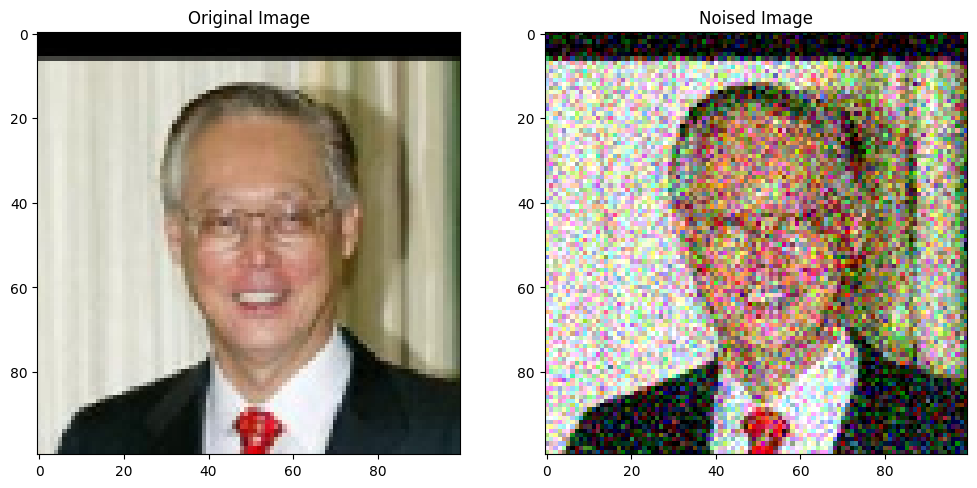

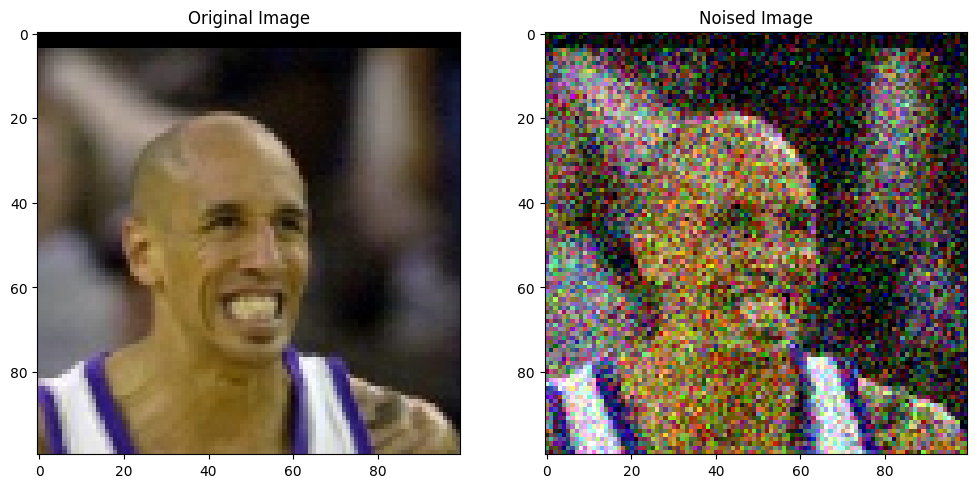

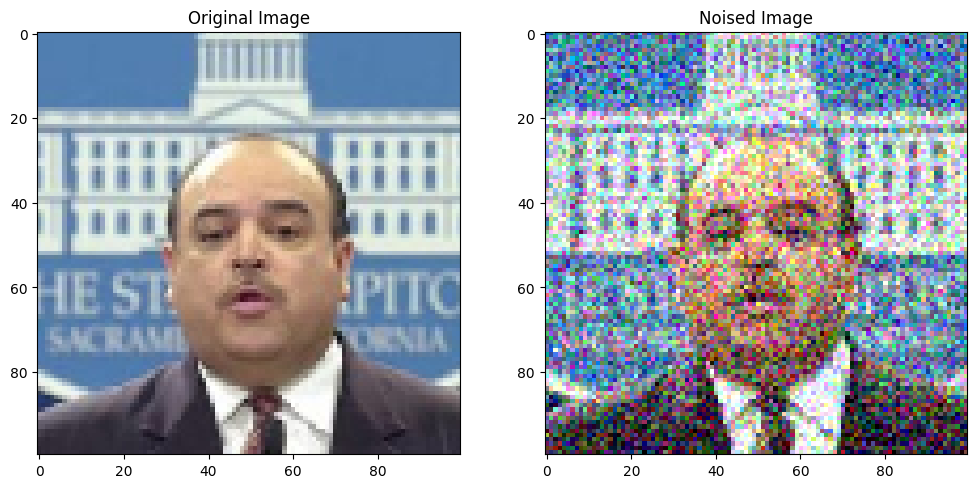

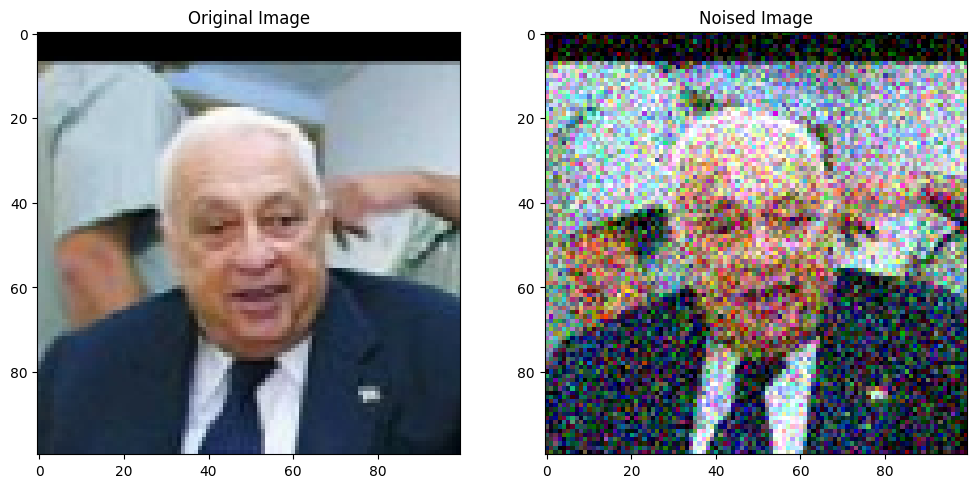

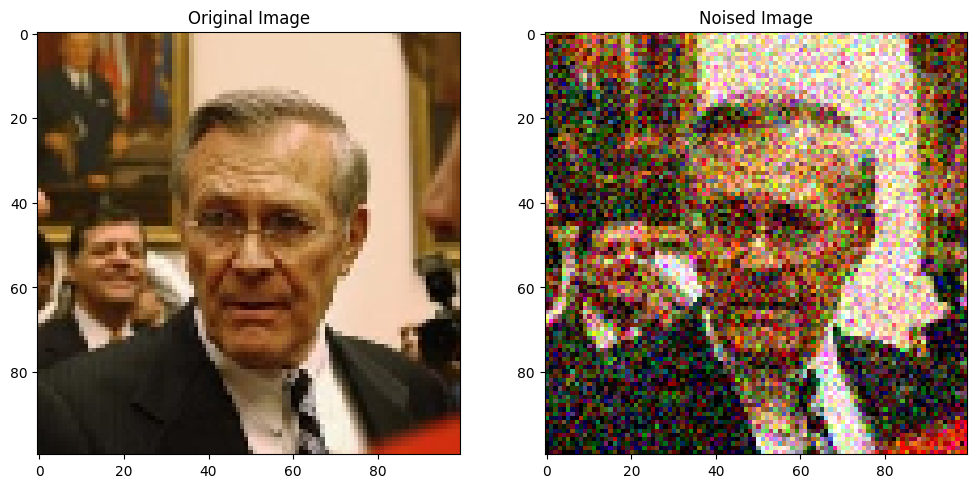

In [ ]:
for i in range(0, 5):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(train_x[i])

    # Denoised Image
    plt.subplot(1, 2, 2)
    plt.title("Noised Image")
    plt.imshow(train_x_noise[i])

    plt.show()

#Lab4.2

In [ ]:
def create_model(optimizer='adam'):
    # Variable input Image
    input_img = Input(shape=(100, 100, 3))
    print(input_img.shape)

    # Encoding
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D((2, 2), strides=2)(x2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)

    # Decoding
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x5 = Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
    x5 = UpSampling2D((2, 2))(x5)
    x6 = Conv2D(128, (3, 3), activation='relu', padding='same')(x5)
    x7 = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
    decoded = Conv2D(3, (3, 3), padding='same')(x7)

    # Construct the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    autoencoder.summary()
    return autoencoder

Train Model

In [ ]:
e = [2,4,6,8,16]
b = [16,32,64,128]
autoencoder = create_model()

callback = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(train_x_noise, train_x,
   epochs=16,
   batch_size=32,
   shuffle=True,
   validation_data=(val_x_noise, val_x),
   callbacks=[callback],verbose=1)

(None, 100, 100, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 128)     295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 5

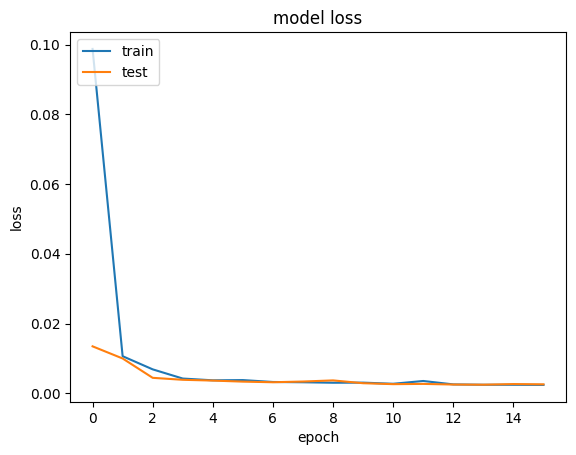

In [ ]:
predictions_test = autoencoder.predict(test_x_noise)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

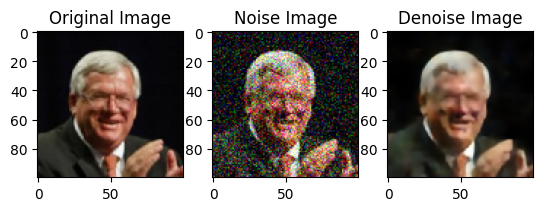

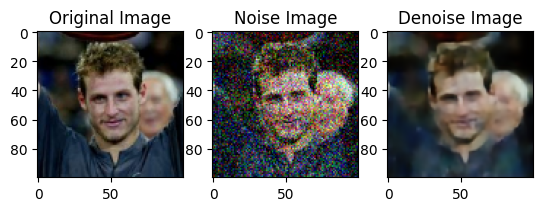

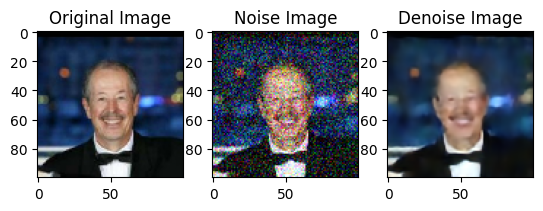

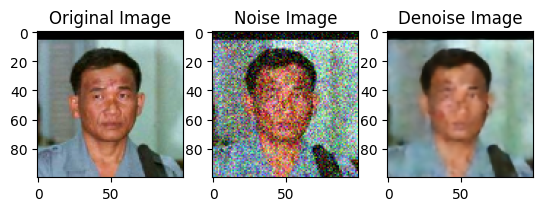

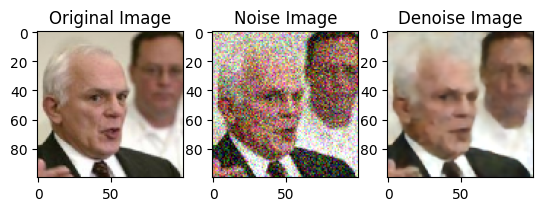

In [ ]:
num_of_plot = 5

for i in range(num_of_plot):
    #Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_x[i])

    #Noise Image
    plt.subplot(1,3,2)
    plt.title("Noise Image")
    plt.imshow(test_x_noise[i])

    #Denoise Image
    plt.subplot(1, 3, 3)
    plt.title("Denoise Image")
    plt.imshow(predictions_test[i])

    plt.show()